In [1]:
#Copyright 2021 Matthew Brownrigg

#Permission is hereby granted, free of charge, to any person obtaining a copy of 
#this software and associated documentation files (the "Software"), to deal in 
#the Software without restriction, including without limitation the rights to 
#use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies 
#of the Software, and to permit persons to whom the Software is furnished to do 
#so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all 
#copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
#THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE 
#SOFTWARE.

In [2]:
import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

from bs4 import BeautifulSoup

In [3]:
url = 'http://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz'

dataset = tf.keras.utils.get_file("domain_sentiment_data", url, untar=True, 
                                  cache_dir='.', cache_subdir='')


dataset_dir = "sorted_data_acl"

In [4]:
os.listdir(dataset_dir)

['books', 'dvd', 'electronics', 'kitchen_&_housewares']

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 6000

In [6]:
reviews = []
labels = [] #List of 1 or 0 (1: Positive, 0: Negative) 
raw_labels = [] #List of scores (Neagtive 1-3, Positive 4-5)

for listing in os.listdir(dataset_dir):
  print("Reading " + listing + "...")
  test = os.path.join(dataset_dir, listing + "/positive.review")

  with open(test, "r") as file:
      # Read each line in the file, readlines() returns a list of lines
      content = file.readlines()
      # Combine the lines in the list into a string
      content = "".join(content)
      bs_content = BeautifulSoup(content, "lxml")

  results = bs_content.find_all("rating")
  for rating in results:
    raw_labels.append(rating.get_text().replace('\n', ''))

  results = bs_content.find_all("review_text")
  for review_text in results:
    reviews.append(review_text.get_text().replace('\n', ''))

  test = os.path.join(dataset_dir, listing + "/negative.review")

  with open(test, "r") as file:
      # Read each line in the file, readlines() returns a list of lines
      content = file.readlines()
      # Combine the lines in the list into a string
      content = "".join(content)
      bs_content = BeautifulSoup(content, "lxml")

  results = bs_content.find_all("rating")
  for rating in results:
    raw_labels.append(rating.get_text().replace('\n', ''))

  results = bs_content.find_all("review_text")
  for review_text in results:
    reviews.append(review_text.get_text().replace('\n', ''))

for label in raw_labels:
  if int(float(label)) > 3:
    labels.append(1)
  else:
    labels.append(0)
   


print("# of reviews: " + str(len(reviews)))
print("reviews [0]: " + reviews[0])
print("# of labels: " + str(len(labels)))
print("labels [0]: " + str(labels[0]))


Reading books...
Reading dvd...
Reading electronics...
Reading kitchen_&_housewares...
# of reviews: 8000
reviews [0]: Sphere by Michael Crichton is an excellant novel. This was certainly the hardest to put down of all of the Crichton novels that I have read. The story revolves around a man named Norman Johnson. Johnson is a phycologist. He travels with 4 other civilans to a remote location in the Pacific Ocean to help the Navy in a top secret misssion. They quickly learn that under the ocean is a half mile long spaceship. The civilans travel to a center 1000 feet under the ocean to live while researching the spacecraft. They are joined by 5 Navy personel to help them run operations. However on the surface a typhoon comes and the support ships on the surface must leave. The team of ten is stuck 1000 feet under the surface of the ocean. After a day under the sea they find out that the spacecraft is actually an American ship that has explored black holes and has brought back some strange

In [7]:
training_sentences = reviews[0:training_size]
testing_sentences = reviews[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("# of training reviews: " + str(len(training_sentences)))
print("# of testing reviews: " + str(len(testing_sentences)))
print("# of training labels: " + str(len(training_labels)))
print("# of testing labels: " + str(len(testing_labels)))

# of training reviews: 6000
# of testing reviews: 2000
# of training labels: 6000
# of testing labels: 2000


In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [9]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 40
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/40
188/188 - 2s - loss: 0.6900 - accuracy: 0.5743 - val_loss: 0.6826 - val_accuracy: 0.6460
Epoch 2/40
188/188 - 1s - loss: 0.6383 - accuracy: 0.7198 - val_loss: 0.6061 - val_accuracy: 0.7300
Epoch 3/40
188/188 - 0s - loss: 0.4952 - accuracy: 0.8195 - val_loss: 0.5123 - val_accuracy: 0.7605
Epoch 4/40
188/188 - 1s - loss: 0.3704 - accuracy: 0.8682 - val_loss: 0.4637 - val_accuracy: 0.7800
Epoch 5/40
188/188 - 1s - loss: 0.2872 - accuracy: 0.9028 - val_loss: 0.4398 - val_accuracy: 0.7875
Epoch 6/40
188/188 - 1s - loss: 0.2311 - accuracy: 0.9258 - val_loss: 0.4368 - val_accuracy: 0.7920
Epoch 7/40
188/188 - 0s - loss: 0.1913 - accuracy: 0.9378 - val_loss: 0.4239 - val_accuracy: 0.8195
Epoch 8/40
188/188 - 0s - loss: 0.1567 - accuracy: 0.9538 - val_loss: 0.4387 - val_accuracy: 0.8115
Epoch 9/40
188/188 - 0s - loss: 0.1342 - accuracy: 0.9617 - val_loss: 0.4621 - val_accuracy: 0.8020
Epoch 10/40
188/188 - 0s - loss: 0.1122 - accuracy: 0.9677 - val_loss: 0.4881 - val_accuracy: 0.7950

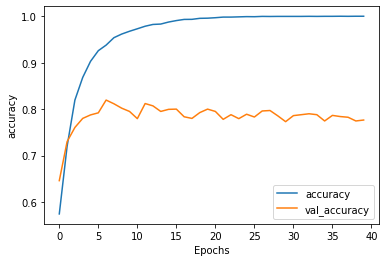

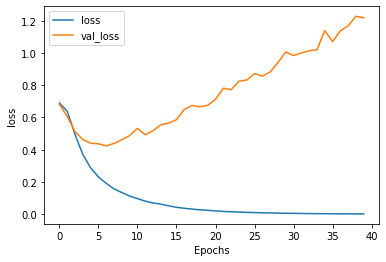

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
sentences = ["The book was awful. I wish I could shove thsi shitty book into the face of who ever wrote this mess.", 
            "The book was truly a gift from the gods. The writing and story is magnificent. I wish I could kiss the author right in his lips."]

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


print(model.predict(padded))

[[0.3294245]
 [0.9666422]]
